# Used tools
* python 3.8
* sympy - to solve derivetives
* numpy - to fastest calculations and work with arrays
* matplotlib - for plotting the graphics

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sympy as sp
from sympy.solvers import solve
%matplotlib inline
matplotlib.style.use("seaborn")
import math

### Initial params of the task

In [2]:
at_max = 10
an_max = 6
v_max = 1.5
x_s, x_f = 0, 4

### Initial equation declaration

In [3]:
A, om, x, th_0 = sp.symbols("A, om, x, \\theta_0")

In [4]:
trajectory = A * sp.sin(om*x + th_0)
trajectory = trajectory.subs({A: 1, om: 3, th_0: 0.2})
trajectory

sin(3*x + 0.2)

The first derivative of the trajectory equation to calculate *curve radius*

In [5]:
trajectory_1d = sp.diff(trajectory, x)
trajectory_1d

3*cos(3*x + 0.2)

The second derivative of the trajectory equation

In [6]:
trajectory_2d = sp.diff(trajectory_1d, x)
trajectory_2d

-9*sin(3*x + 0.2)

To calculate the curve radius we can use the formula

$$ r(x) = \frac{(\sqrt{1+(y')^2})^3}{|y''|} $$

In [7]:
radius = (sp.sqrt(1+trajectory_1d**2))**3/abs(trajectory_2d)
radius

(9*cos(3*x + 0.2)**2 + 1)**(3/2)/(9*Abs(sin(3*x + 0.2)))

To calculate the max normal acceleration lets use the formula

$$ a_n(x) = \frac{v_{max}^2}{r(x)} $$

In [8]:
an = v_max**2 / radius
an

20.25*Abs(sin(3*x + 0.2))/(9*cos(3*x + 0.2)**2 + 1)**(3/2)

Same actions with max velocity

$$ v(x) = \sqrt{a_{n_{max}} * r(x)} $$

In [9]:
v = sp.sqrt(an_max * radius)
v

sqrt(6)*sqrt((9*cos(3*x + 0.2)**2 + 1)**(3/2)/Abs(sin(3*x + 0.2)))/3

Lets take the step for simulation $dx=1/10000$

And calculate $y(x)$ 

In [10]:
dx = 10000
X = np.linspace(x_s, x_f, dx)
Yx = np.array([trajectory.subs(x, val) for val in X])
R = np.array([radius.subs(x, val) for val in X])

#### The graphic $y(x)$ 

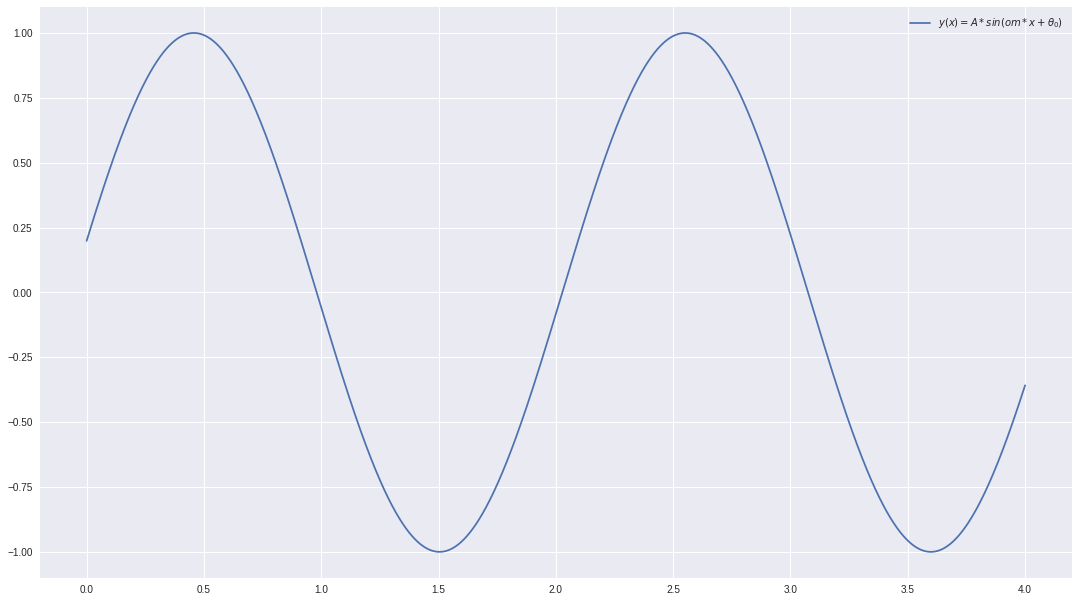

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(X, Yx, label=r"$y(x)=A*sin(om*x+\theta_0)$")
plt.legend()
plt.show()

Now we can calculate the velocity for all trjectory with condition of max tangential acceleration

In [12]:
Vx = np.array([min(v.subs(x, val), v_max) for val in X])

#### The graphic of $v(x)$ without including the start and finish

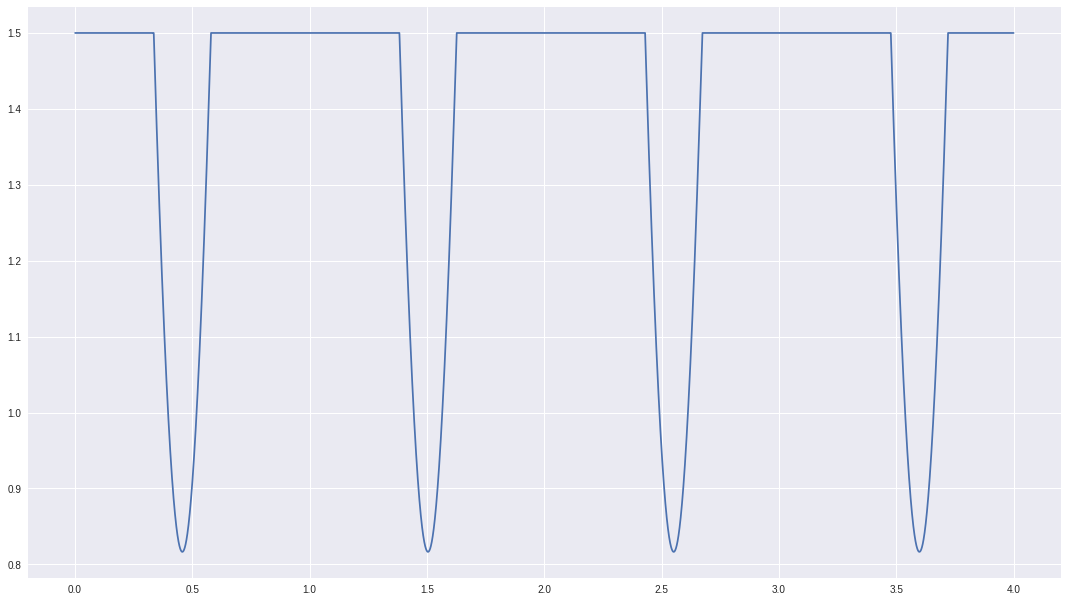

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(X, Vx)
plt.show()

### The useful function

In [14]:
def get_dist(x_arr, y_arr):
    ddy = np.power(y_arr[1:]-y_arr[:-1], 2)
    ddx = np.power(x_arr[1:]-x_arr[:-1], 2)
    ds = np.power(ddy+ddx, 1/2)
    return ds

def timer(x_arr, y_arr, v_arr):
    dv = (v_arr[1:]+v_arr[:-1]) / 2
    ds = get_dist(x_arr, y_arr)
    t_arr = ds / dv
    print(float(np.sum(t_arr)))
    t_list = [0]
    for i, t in enumerate(t_arr):
        t_list.append(t_list[i] + t)
    return t_list

Time without starting and finishing steps

In [15]:
T = timer(X, Yx, Vx)

6.156015045352362


To calculate the velocity from time we can use the formula

$$ S_i = \frac{v_i^2 - v_{i-1}^2}{2a_{\tau_{max}}} $$

Where $ S_i = \sqrt{(x_i - x_{i-1})^2 + (y_i - y_{i-1})^2} $

Then we have the formula

$$ v_i = \sqrt{2*S_i*a_{\tau_{max}} + v_{i-1}^2} $$

Now we need to compare $V_i$ with $V_{i}(x)$, which we found in the previous step. This is required to not break previous bounds. And at the second step, we can implement the same formula to calculate velocity for finishing, but we need to do it into the reverse steps. And finaly we need to merge them into the one with comparing. 

In [16]:
def calculate_velocity(x_arr, y_arr, v_arr):
    ds = get_dist(x_arr, y_arr)
    v_s = [0]
    for i in range(dx - 1):
        v_b = np.power(2*ds[i]*at_max + v_s[i] ** 2,1/2)
        v_s.append(min(v_b, v_arr[i]))
    v_e = [0]
    for i in range(dx-2, -1, -1):
        v_b = np.power(2*ds[::-1][i]*at_max + v_e[0] ** 2,1/2)
        v_e.insert(0, min(v_b, v_arr[i]))
    v_t = []
    for i in range(dx):
        v_t.append(min(v_s[i], v_e[i]))
    return np.array(v_t)

In [17]:
Vt = calculate_velocity(X, Yx, Vx)

At this step we can calculate the tangent acceleration using the formula from the previous step:

$$ a_{\tau} = \frac{v_i^2 - v_{i-1}^2}{2*S_i} $$

In [18]:
def calculate_tangent_acceleration(x_arr, y_arr, v_arr):
    ds = get_dist(x_arr, y_arr)
    atd = (np.power(v_arr[1:], 2) - np.power(v_arr[:-1], 2)) / (2*ds)
    return np.append(atd, 0)

In [19]:
ATt = calculate_tangent_acceleration(X, Yx, Vt)

### The final time

To calculate the time we can find it by:

$$ dt = \frac{2*S_i}{v_i + v_{i+1}} $$

In [20]:
T0 = timer(X, Yx, Vt)

6.304770049682114


In [21]:
def calculate_path_by_time(x_arr, y_arr):
    path = get_dist(x_arr, y_arr)
    yt = [0]
    for val in path:
        yt.append(val + yt[-1])
    return np.array(yt)

def graphic(x_axis, y_axis, label, color):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.title(label)
    ax.plot(x_axis, y_axis, color, label=label)
    plt.legend()
    plt.plot()    

Lets calculate the $y(t)$

In [22]:
Yt = calculate_path_by_time(X, Yx)

To calculate the normal acceleration we can use the formula

$$ a_n(t) = \frac{v(t)^2}{r(t)} $$

In [23]:
ANt = np.power(Vt, 2) / R

### The plot $y(x)$

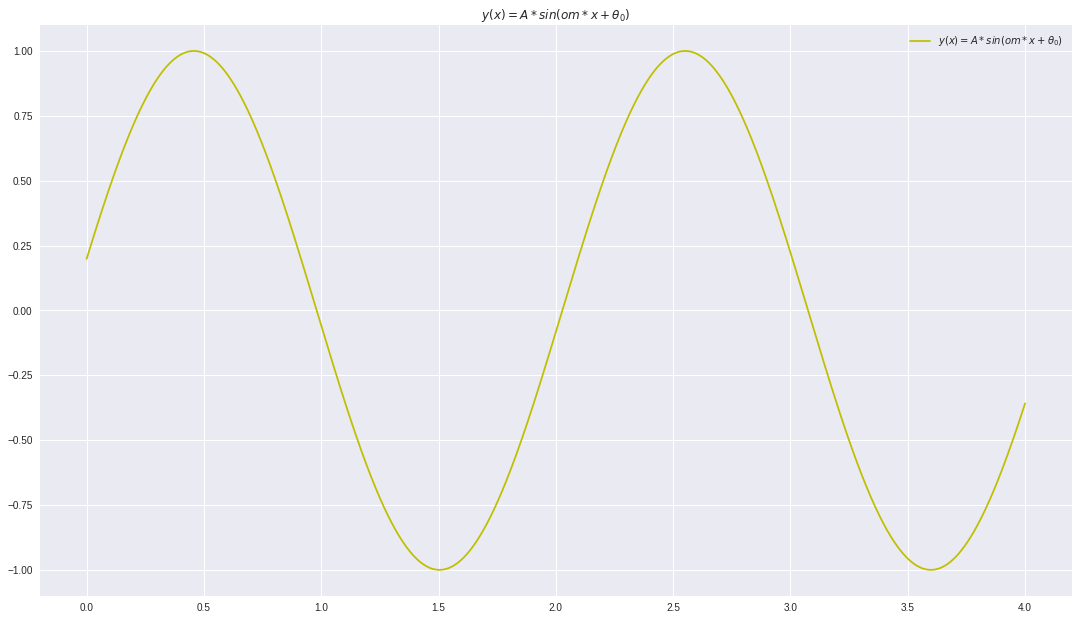

In [24]:
graphic(X, Yx, r"$y(x)=A*sin(om*x+\theta_0)$", "y-")

### The plot $y(t)$

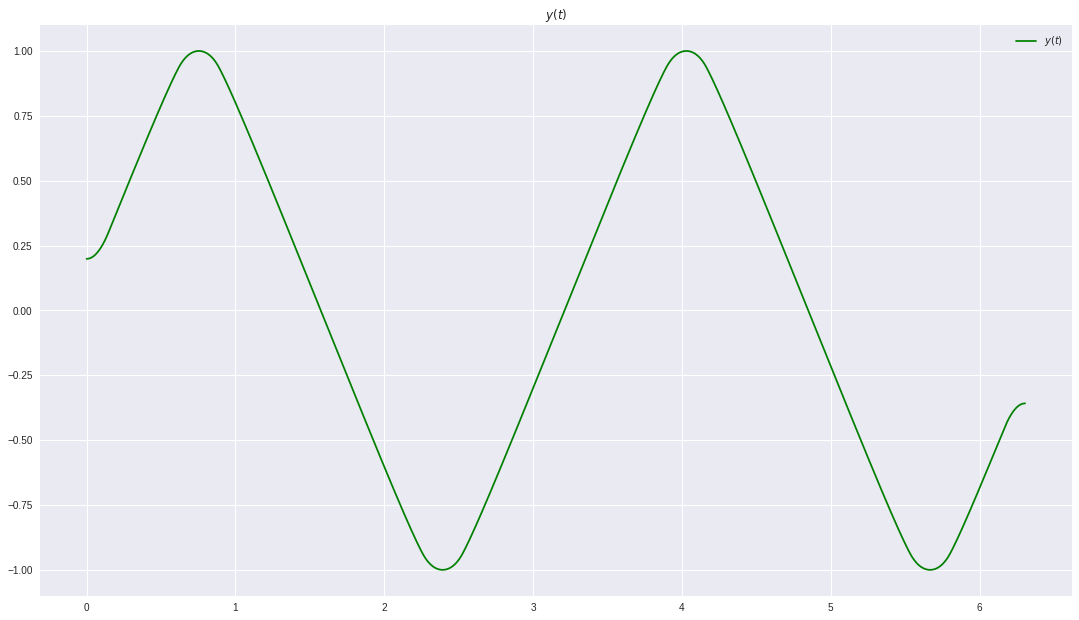

In [25]:
graphic(T0, Yx, r"$y(t)$", "g-")

### The plot $v(t)$

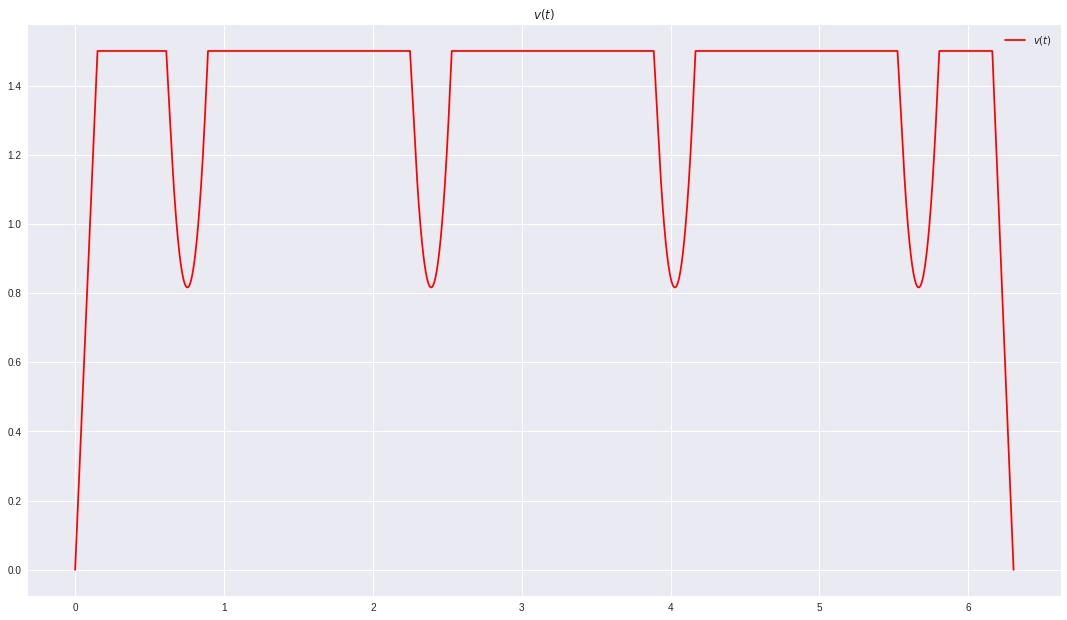

In [26]:
graphic(T0, Vt, r"$v(t)$", "r-")

### The plot $a_{\tau}(t)$

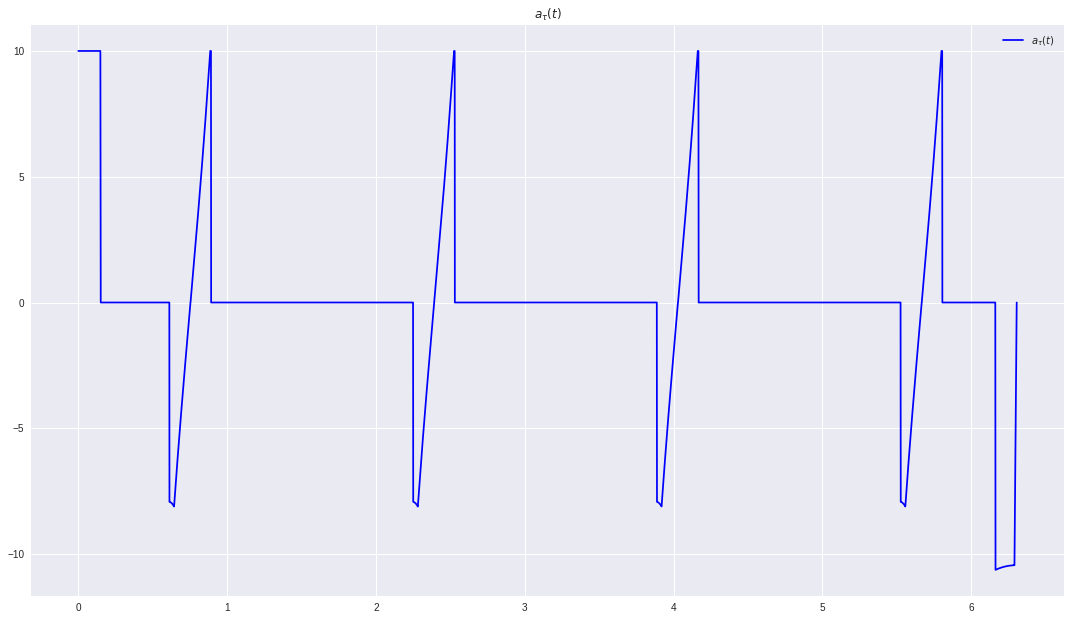

In [27]:
graphic(T0, ATt, r"$a_{\tau}(t)$", "b-")

### The plot $a_n(t)$

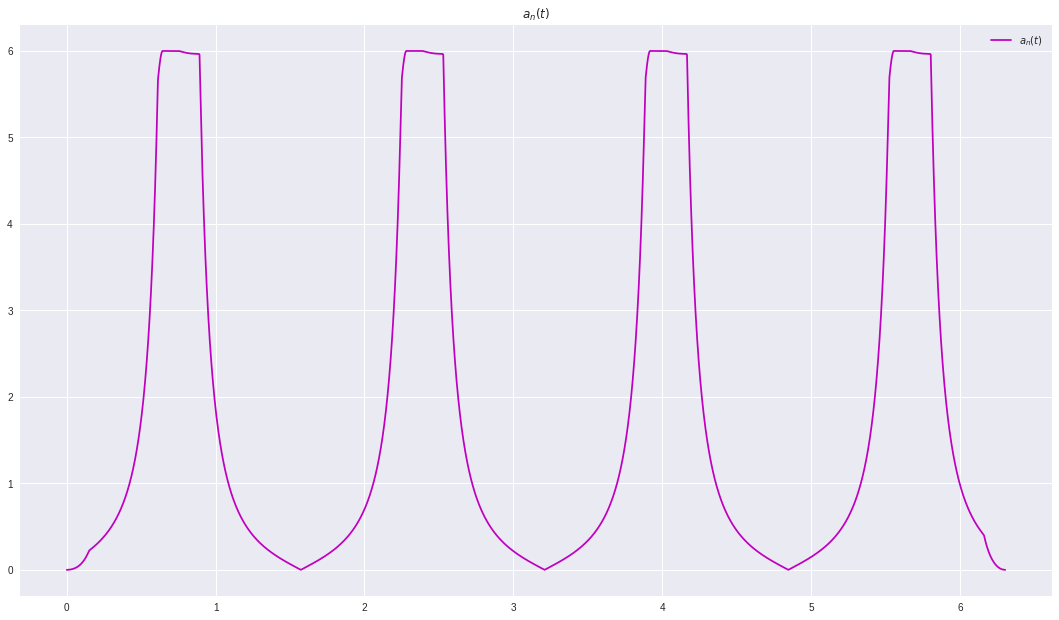

In [28]:
graphic(T0, ANt, r"$a_n(t)$", "m-")